In [300]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing.data import QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
project_dir = 'C:\\Users\\PLDD\\python\\Python\\ML\\Kaggle\\house_price'
raw_path = os.path.join(project_dir,'data','raw')
train_path = os.path.join(raw_path, 'train.csv')
test_path = os.path.join(raw_path, 'test.csv')
sns.set()

In [301]:
def GetTrainTestSets(train_path, test_path):   
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    col = ['FireplaceQu','Alley','PoolQC','Fence','MiscFeature']
    train[col] = train[col].fillna(value = 'None')
    test[col] = test[col].fillna(value = 'None')
    
    catcol = [['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2'],
              ['GarageType','GarageFinish','GarageQual','GarageCond']]
    numcol = [['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath'],
              ['GarageYrBlt','GarageCars','GarageArea']]
    keyflds = ['TotalBsmtSF','GarageArea']
    for (catflds,numflds,keyfld) in zip(catcol, numcol, keyflds):
        lx = (train[keyfld] == 0) & (train[catflds].isnull().any(axis = 1))
        train.loc[lx,catflds] = train[lx][catflds].fillna(value = 'None')
        lx = (train[keyfld] == 0) & (train[numflds].isnull().any(axis = 1))
        train.loc[lx,numflds] = train[lx][numflds].fillna(value = 0)
        lx = (test[keyfld] == 0) & (test[catflds].isnull().any(axis = 1))
        test.loc[lx,catflds] = test[lx][catflds].fillna(value = 'None')
        lx = (test[keyfld] == 0) & (test[numflds].isnull().any(axis = 1))
        test.loc[lx,numflds] = test[lx][numflds].fillna(value = 0)
    train = train.drop('Utilities', axis = 1)
    test = test.drop('Utilities', axis = 1)
    return (train, test)

In [302]:
def ProccessOutliers(train, test):
    lx1 = (train['SalePrice'] <= 200000) & (train['GrLivArea'] >= 4000) 
    lx2 = train['LotFrontage'] > 300 
    lx = lx1 | lx2
    train = train[~lx]
    return (train, test)

In [303]:
def ProcessFeature(train, test):
    train['SalePrice'] = np.log1p(train['SalePrice'])
    return (train, test)

In [304]:
def FindRegresion(df,fld):
    scaler = QuantileTransformer()
    param_grid = {'alpha': [1e0,0.5, 0.1, 1e-2, 1e-3,1e-4,1e-5,1e-6],'gamma': np.logspace(-4, 2, 14)}
    solver = GridSearchCV(KernelRidge(kernel = 'rbf'), cv=8, param_grid=param_grid)
    #solver = linear_model.RidgeCV(alphas = np.arange(0.001, 5, 0.001))
    
    df = pd.get_dummies(df)
    lx = df[fld].isnull()
    dfy = df[fld]
    dfx = df.drop(fld, axis = 1)
    X = dfx[~lx].as_matrix().astype('float')
    y = dfy[~lx].ravel()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    solver.fit(X_train, y_train)
    print(solver.score(X_test, y_test))

    X = scaler.fit_transform(X)    
    XX = scaler.transform(dfx[lx].as_matrix().astype('float'))
    solver.fit(X, y) 
    yy = solver.predict(XX).astype('float')
    dfy[lx] = yy
    return dfy

In [305]:
def PreprocessAll(df):
    df['MSSubClass'] = df['MSSubClass'].apply(str)
    df['OverallCond'] = df['OverallCond'].astype(str)
    df['YrSold'] = df['YrSold'].astype(str)
    df['MoSold'] = df['MoSold'].astype(str)
    return df

In [306]:
def ProccessNumNans(df):
    fld = 'LotFrontage'
    df.loc[:,[fld]] = FindRegresion(df[['LotFrontage','Neighborhood','LotConfig','LotArea']],fld)
    
    lx = (df['MasVnrArea'] != 0) & (df['MasVnrType'] == 'None')
    df.loc[lx,'MasVnrArea'] = 0.0
    lx = (df['MasVnrArea'] == 0) & (df['MasVnrType'] != 'None')
    df.loc[lx,'MasVnrType'] = 'None'
    
    numflds = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2']
    catflds = ['MasVnrType', 'BsmtFinType1','BsmtFinType2']

    for (catfld, numfld) in zip(catflds,numflds):
        lx = df[numfld].isnull()
        tmp = df.groupby([catfld])[numfld].describe()
        df.loc[lx,numfld] = np.sum(tmp['50%'] * tmp['count'] / tmp['count'].sum())   
        
    fld = 'TotalBsmtSF'
    lx = df[fld].isnull()
    df.loc[lx,fld] = df[lx][['BsmtFinSF1', 'BsmtFinSF2']].sum(axis = 1)
    
    fld = 'BsmtUnfSF'
    lx = df[fld].isnull()
    df.loc[lx,fld] = df[lx]['TotalBsmtSF'] - df[lx][['BsmtFinSF1', 'BsmtFinSF2']].sum(axis = 1)
    
    flds = ['BsmtFullBath','BsmtHalfBath'] 
    lx = df['BsmtFullBath'].isnull()
    df.loc[lx,['BsmtFullBath','BsmtHalfBath']]= df[~lx][['BsmtFullBath','BsmtHalfBath']].mean(axis = 0).values
    
    lx = df['GarageYrBlt'].isnull()
    df.loc[lx,'GarageYrBlt'] = df[lx]['YearRemodAdd']
    lx = df['GarageCars'].isnull()
    df.loc[lx,'GarageCars'] = df[~lx]['GarageCars'].mean()
    lx = df['GarageArea'].isnull()
    df.loc[lx,'GarageArea'] = df[~lx]['GarageArea'].median()
    return df

In [307]:
def ProccessCategoricalNans(df):
    oldflds = []
    newdf = pd.DataFrame()
######################## 1) MSZoning - 'RL', 'RM', 'C (all)', 'FV', 'RH', nan ############################
    colname = 'MSZoning'
    oldflds.append(colname)
    #### with Mitchel neighbor it is highly likely that zoning is 'RL' (grouping by Neighbors + BuiltYear)
    lx=(df[colname].isnull()) & (df['Neighborhood'] == 'Mitchel')  
    df.loc[lx,colname] = 'RL'
    ### group by IDOTRR neighbor
    invalidlx = df[colname].isnull() 
    idotrrlx = df['Neighborhood'] == 'IDOTRR'

    tempdf = pd.get_dummies(df[colname],prefix = colname).astype(float)
    tempdf.loc[invalidlx,:] = tempdf[idotrrlx].sum().values / tempdf[idotrrlx].sum().sum()
    newdf[tempdf.columns] = tempdf
######################## 2) ordered categorias
    catflds = ['FireplaceQu','ExterQual','ExterCond','HeatingQC','PoolQC','LandSlope','LotShape',
               'PavedDrive','Street','Alley','CentralAir','MSSubClass','OverallCond','YrSold','MoSold']
    df['FireplaceQu'] = pd.Categorical(df['FireplaceQu'].values,  ['None','Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered = True)
    df['ExterQual'] = pd.Categorical(df['ExterQual'].values, ['Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered = True)
    df['ExterCond'] = pd.Categorical(df['ExterCond'].values, ['Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered = True)
    df['HeatingQC'] = pd.Categorical(df['HeatingQC'].values, ['Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered = True)
    df['PoolQC'] = pd.Categorical(df['PoolQC'].values, ['None', 'Fa', 'TA', 'Gd', 'Ex'], ordered = True)
    df['LandSlope'] = pd.Categorical(df['LandSlope'].values, ['Sev', 'Mod', 'Gtl'], ordered = True)
    df['LotShape'] = pd.Categorical(df['LotShape'].values, ['Reg', 'IR1', 'IR2', 'IR3'], ordered = True)
    df['PavedDrive'] = pd.Categorical(df['PavedDrive'].values, ['N', 'P', 'Y'], ordered = True)
    df['Street'] = pd.Categorical(df['Street'].values, ['Grvl','Pave'], ordered = True)
    df['Alley'] = pd.Categorical(df['Alley'].values, ['None', 'Grvl', 'Pave'], ordered = True)
    df['CentralAir'] = pd.Categorical(df['CentralAir'].values, ['N', 'Y'], ordered = True)
    df['MSSubClass'] = pd.Categorical(df['MSSubClass'].values, ['20','30','40','45','50','60','70','75','80','85','90','120','150','160','180','190'], ordered = True)
    df['OverallCond'] = pd.Categorical(df['OverallCond'].values, ['1','2','3','4','5','6','7','8','9'], ordered = True)
    df['YrSold'] = pd.Categorical(df['YrSold'].values, ['2006','2007','2008','2009','2010'], ordered = True)
    df['MoSold'] = pd.Categorical(df['MoSold'].values, ['1','2','3','4','5','6','7','8','9','10','11','12'], ordered = True)

    nanflds = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','KitchenQual',
               'GarageFinish', 'GarageQual','GarageCond']
    df['BsmtQual'] = pd.Categorical(df['BsmtQual'].values, ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered = True)
    df['BsmtCond'] = pd.Categorical(df['BsmtCond'].values, ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered = True)
    df['BsmtExposure'] = pd.Categorical(df['BsmtExposure'].values, ['None', 'No', 'Mn', 'Av', 'Gd'], ordered = True)
    df['BsmtFinType1'] = pd.Categorical(df['BsmtFinType1'].values, ['None','Unf','LwQ', 'Rec','BLQ','ALQ','GLQ'], ordered = True)
    df['BsmtFinType2'] = pd.Categorical(df['BsmtFinType2'].values, ['None','Unf','LwQ', 'Rec','BLQ','ALQ','GLQ'], ordered = True)
    df['KitchenQual'] = pd.Categorical(df['KitchenQual'].values, ['Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered = True)
    df['GarageFinish'] = pd.Categorical(df['GarageFinish'].values, ['None', 'Unf', 'RFn', 'Fin'], ordered = True)
    df['GarageQual'] = pd.Categorical(df['GarageQual'].values, ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered = True)
    df['GarageCond'] = pd.Categorical(df['GarageCond'].values, ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered = True)
    df.loc[:,catflds + nanflds] = df[catflds + nanflds].apply(lambda x: x.cat.codes).astype('float')
    for fld in nanflds:
        lx = df[fld] < 0.0
        df.loc[lx,fld] = df[~lx][fld].mean()
######################## 3) 'Exterior1st', 'Exterior2nd','MasVnrType','Electrical','KitchenQual'#############
########################'BsmtQual', 'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2'##################
######################## 'Functional','GarageType', 'GarageFinish', 'GarageQual','GarageCond'################
######################## 'PoolQC','SaleType'#################################################################   
    catflds = ['Exterior1st','Exterior2nd','MasVnrType','Electrical','GarageType','SaleType','Functional']
    for fld in catflds:
        lx = df[fld].isnull()
        oldflds.append(fld)
        tmp = pd.get_dummies(df[fld],prefix = fld).astype(float)
        tmp.loc[lx,:] = tmp[~lx].sum().values / tmp[~lx].sum().sum()
        newdf[tmp.columns] = tmp
    df = df.drop(labels = oldflds,axis = 1)
    df[newdf.columns] = newdf
    df = pd.get_dummies(df).astype(float)
    return df

In [308]:
def FormatAndSave(df):
    processed_data_path = os.path.join(os.path.pardir,'data','processed')
    write_train_path = os.path.join(processed_data_path, 'train.csv')
    write_test_path = os.path.join(processed_data_path, 'test.csv')
    train_df = df[df['SalePrice'] != 0]
    train_df.loc[:,'Id'] = train_df['Id'].astype('int32').values
    test_df = df[df['SalePrice'] == 0]
    test_df = test_df.drop(labels = 'SalePrice',axis = 1)
    test_df.loc[:,'Id'] = test_df['Id'].astype('int32').values
    train_df.to_csv(write_train_path)
    test_df.to_csv(write_test_path) 
    return (df,train_df,test_df)

In [309]:
def GetResultData(train_path, test_path):
    (train, test) = GetTrainTestSets(train_path, test_path)
    (train, test) = ProccessOutliers(train, test)
    (train, test) = ProcessFeature(train, test)
    train1 = train
    test1 = test
    test['SalePrice'] = 0
    return (train.append(test), train1, test1)

In [310]:
(df, train, test) = GetResultData(train_path, test_path)
(df, train, test) = df.pipe(PreprocessAll).pipe(ProccessNumNans).pipe(ProccessCategoricalNans).pipe(FormatAndSave)

C:\Users\PLDD\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.5746792959581691


C:\Users\PLDD\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\PLDD\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\PLDD\Anaconda3\lib\site-packages\pandas\core\indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


#  Build model

In [311]:
processed_data_path = os.path.join(os.path.pardir,'data','processed')
train_path = os.path.join(processed_data_path, 'train.csv')
test_path = os.path.join(processed_data_path, 'test.csv')
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
test_df = test_df.drop(labels = ['Unnamed: 0'],axis = 1)
train_df = train_df.drop(labels = ['Id','Unnamed: 0'],axis = 1)

In [322]:
def linear_ml_solve(train_df, test_df, scaler, solver, q = 0.4, target = 'temp.csv'):
    collx = train_df.columns != 'SalePrice'
    X = train_df.loc[:,collx ].as_matrix().astype('float')
    y = train_df['SalePrice'].ravel()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=q, random_state=0)
    X_train = scaler.fit_transform(X_train)
    if q != 0:
        X_test = scaler.transform(X_test)
        solver.fit(X_train, y_train)
        print(solver.score(X_test, y_test))
    else: 
        print("No test subsets!!!!")
    X = scaler.fit_transform(X)  
    ids = test_df['Id'].values
    test_df = test_df.drop(labels = 'Id',axis = 1)
    XX = scaler.transform(test_df.as_matrix().astype('float'))
    solver.fit(X, y) 
    pred_y = solver.predict(XX).astype('float')
    df_submission = pd.DataFrame({'Id': ids, 'SalePrice' : np.exp(pred_y) - 1.0} )
    submission_data_path = os.path.join(os.path.pardir,'data','external')
    submission_file_path = os.path.join(submission_data_path, target)
    df_submission.to_csv(submission_file_path, index=False)
    return df_submission

# Preprocessing Scaling

In [323]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing.data import QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

scaler1 = StandardScaler()
scaler2 = MinMaxScaler()
scaler3 = RobustScaler()
scaler4 = Normalizer()
scaler5 = QuantileTransformer()

# ML

In [324]:
solver1 = linear_model.RidgeCV(alphas = np.arange(0.001, 5, 0.001))
solver2 = linear_model.LassoCV()
solver3 = linear_model.ElasticNetCV(alphas = np.arange(0.001, 5, 0.001), max_iter = 20000 )
solver4 = linear_model.BayesianRidge()
solver6 = linear_model.PassiveAggressiveRegressor(C = 10,tol = 0.00001, max_iter = 50000)
solver7 = linear_model.HuberRegressor(max_iter=10000)
solver8 = Pipeline([('poly', PolynomialFeatures(degree=2)),  ('linear', solver1)])

param_grid = {
    'alpha': [1e0,0.5, 0.1, 1e-2, 1e-3,1e-4,1e-5,1e-6],
    'gamma': np.logspace(-4, 2, 14)
}
solver5_1 = GridSearchCV(KernelRidge(kernel = 'polynomial',degree = 80), cv=8, param_grid=param_grid)
solver5_2 = GridSearchCV(KernelRidge(kernel = 'rbf'), cv=8, param_grid=param_grid)

In [325]:

subm = linear_ml_solve(train_df, test_df, scaler5, solver5_2, 0.4,'11_KernelRidge_RBF.csv')

C:\Users\PLDD\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.9059284432008149


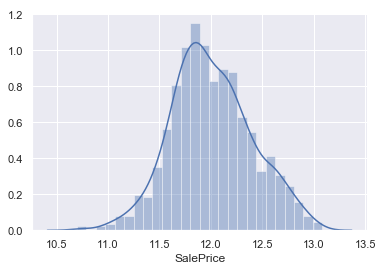

In [328]:
sns.distplot(np.log1p(subm['SalePrice']))